# Introduction
Text classification algorithms are at the heart of a variety of software systems that process text data at scale. Email software uses text classification to determine whether incoming mail is sent to the inbox or filtered into the spam folder. Discussion forums use text classification to determine whether comments should be flagged as inappropriate.

These are two examples of topic classification, categorizing a text document into one of a predefined set of topics. In many topic classification problems, this categorization is based primarily on keywords in the text.

![](img/TextClassificationExample.png)
<p style="text-align:center">**Figure 1: Topic classification is used to flag incoming spam emails, which are filtered into a spam folder.**</p>

Another common type of text classification is **sentiment analysis**, whose goal is to identify the polarity of text content: the type of opinion it expresses. This can take the form of a binary like/dislike rating, or a more granular set of options, such as a star rating from 1 to 5. Examples of sentiment analysis include analyzing Twitter posts to determine if people liked the Black Panther movie, or extrapolating the general public’s opinion of a new brand of Nike shoes from Walmart reviews.

This guide will teach you some key machine learning best practices for solving text classification problems. Here’s what you’ll learn:
* The high-level, end-to-end workflow for solving text classification problems using machine learning
* How to choose the right model for your text classification problem
* How to implement your model of choice using TensorFlow

## Text Classification Workflow
Here’s a high-level overview of the workflow used to solve machine learning problems:

* Step 1: Gather Data
* Step 2: Explore Your Data
* Step 2.5: Choose a Model*
* Step 3: Prepare Your Data
* Step 4: Build, Train, and Evaluate Your Model
* Step 5: Tune Hyperparameters
* Step 6: Deploy Your Model
![](img/Workflow.png) 
<p style="text-align:center">**Figure 2: Workflow for solving machine learning problems**</p>

<table align="left"><tr><td bgcolor='#E1F5FE'>
<p>**Note:** “Choose a model” is not a formal step of the traditional machine learning workflow; however, selecting an appropriate model</p>
<p>for your problem is a critical task that clarifies and simplifies the work in the steps that follow.</p>
</td></tr></table>

The following sections explain each step in detail, and how to implement them for text data.
# Step 1: Gather Data
Gathering data is the most important step in solving any supervised machine learning problem. Your text classifier can only be as good as the dataset it is built from.

If you don’t have a specific problem you want to solve and are just interested in exploring text classification in general, there are plenty of open source datasets available. You can find links to some of them in our [GitHub repo](https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py). On the other hand, if you are tackling a specific problem, you will need to collect the necessary data. Many organizations provide public APIs for accessing their data—for example, the [Twitter API](https://dev.twitter.com/rest/public) or the [NY Times API](http://developer.nytimes.com/). You may be able to leverage these for the problem you are trying to solve.

Here are some important things to remember when collecting data:

* If you are using a public API, understand the _limitations_ of the API before using them. For example, some APIs set a limit on the rate at which you can make queries.  


* The more training examples (referred to as _samples_ in the rest of this guide) you have, the better. This will help your model generalize better.  


* Make sure the number of samples for every _class_ or topic is not overly _imbalanced_. That is, you should have comparable number of samples in each class.  


* Make sure that your samples adequately cover the _space of possible inputs_, not only the common cases.  

Throughout this guide, we will use the [Internet Movie Database (IMDb) movie reviews dataset](http://ai.stanford.edu/~amaas/data/sentiment/) to illustrate the workflow. This dataset contains movie reviews posted by people on the IMDb website, as well as the corresponding labels (“positive” or “negative”) indicating whether the reviewer liked the movie or not. This is a classic example of a sentiment analysis problem.

# Step 2: Explore Your Data
Building and training a model is only one part of the workflow. Understanding the characteristics of your data beforehand will enable you to build a better model. This could simply mean obtaining a higher accuracy. It could also mean requiring less data for training, or fewer computational resources.

## Load the Dataset
First up, let’s load the dataset into Python.

In [1]:
import os
import random

def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname), 'r', encoding='utf-8') as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname), 'r', encoding='utf-8') as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

## Check the Data
After loading the data, it’s good practice to **run some checks** on it: pick a few samples and manually check if they are consistent with your expectations. For example, print a few random samples to see if the sentiment label corresponds to the sentiment of the review. Here is a review we picked at random from the IMDb dataset: _“Ten minutes worth of story stretched out into the better part of two hours. When nothing of any significance had happened at the halfway point I should have left.”_ The expected sentiment (negative) matches the sample’s label.

## Collect Key Metrics
Once you’ve verified the data, collect the following important metrics that can help characterize your text classification problem:

1. **Number of samples**: Total number of examples you have in the data.

2. **Number of classes**: Total number of topics or categories in the data.

3. **Number of samples per class**: Number of samples per class (topic/category). In a balanced dataset, all classes will have a similar number of samples; in an imbalanced dataset, the number of samples in each class will vary widely.

4. **Number of words per sample**: Median number of words in one sample.

5. **Frequency distribution of words**: Distribution showing the frequency (number of occurrences) of each word in the dataset.

6. **Distribution of sample length**: Distribution showing the number of words per sample in the dataset.

Let’s see what the values for these metrics are for the IMDb reviews dataset (See Figures 3 and 4 for plots of the word-frequency and sample-length distributions).

<p align="left">Metric name|Metric value</p>
:---|:--:
<p align="left">Number of samples</p>|<center>25000</center>
<p align="left">Number of classes</p>|<center>2</center>
<p align="left">Number of samples per class</p>|<center>12500</center>
<p align="left">Number of words per sample</p>|<center>174</center>


<p style="text-align:center">**Table 1: IMDb reviews dataset metrics**</p>

[explore_data.py](https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/explore_data.py) contains functions to calculate and analyse these metrics. Here are a couple of examples:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

In [3]:
data_path = 'x:/E/CodeBases/AI/NLP/Corpus'
(train_texts, _), (test_texts, _) = load_imdb_sentiment_analysis_dataset(data_path)
sample_texts = train_texts + test_texts
plt.rcParams['figure.figsize'] = (12, 8)

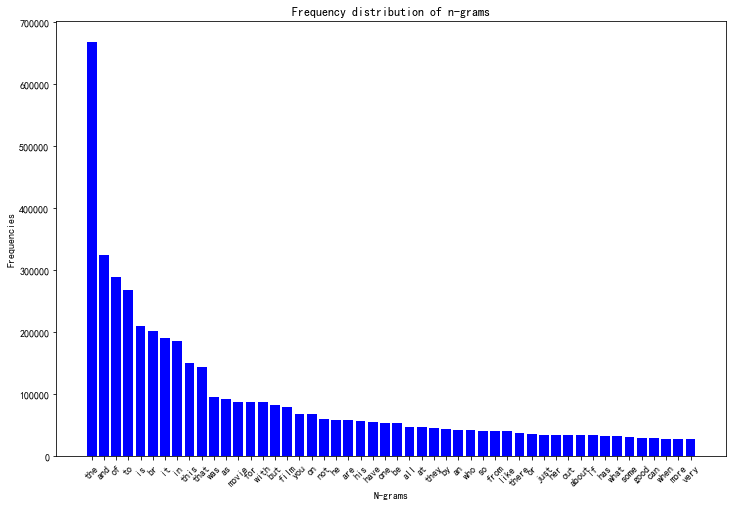

In [4]:
plot_frequency_distribution_of_ngrams(sample_texts)

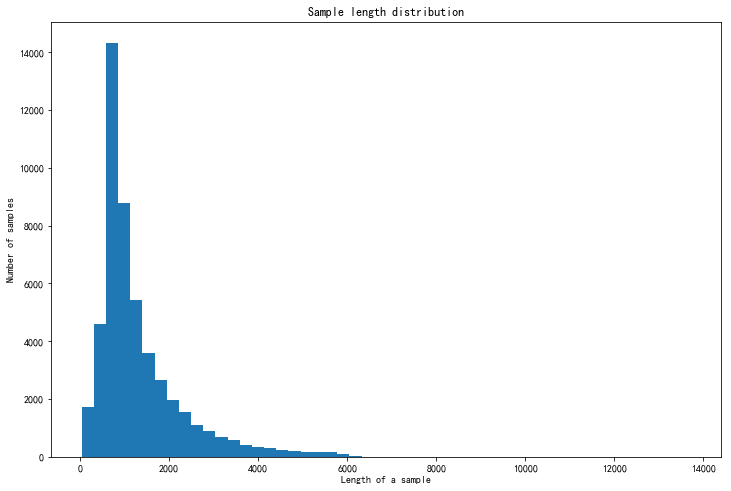

In [5]:
plot_sample_length_distribution(sample_texts)


# Step 2.5: Choose a Model
At this point, we have assembled our dataset and gained insights into the key characteristics of our data. Next, based on the metrics we gathered in [Step 2](), we should think about which classification model we should use. This means/ asking questions such as, “How do we present the text data to an algorithm that expects numeric input?” (this is called data preprocessing and vectorization), “What type of model should we use?”, “What configuration parameters should we use for our model?”, etc.

Thanks to decades of research, we have access to a large array of data preprocessing and model configuration options. However, the availability of a very large array of viable options to choose from greatly increases the complexity and the scope of the particular problem at hand. Given that the best options might not be obvious, a naive solution would be to try every possible option exhaustively, pruning some choices through intuition. However, that would be tremendously expensive.

In this guide, we attempt to significantly simplify the process of selecting a text classification model. For a given dataset, our goal is to find the algorithm that achieves close to maximum accuracy while minimizing computation time required for training. We ran a large number (~450K) of experiments across problems of different types (especially sentiment analysis and topic classification problems), using 12 datasets, alternating for each dataset between different data preprocessing techniques and different model architectures. This helped us identify dataset parameters that influence optimal choices.

The model selection algorithm and flowchart below are a summary of our experimentation. Don’t worry if you don’t understand all the terms used in them yet; the following sections of this guide will explain them in depth.

## Algorithm for Data Preparation and Model Building

```
1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a
simple multi-layer perceptron (MLP) model to classify them (left branch in the
flowchart below):
  a. Split the samples into word n-grams; convert the n-grams into vectors.
  b. Score the importance of the vectors and then select the top 20K using the scores.
  c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a
   sepCNN model to classify them (right branch in the flowchart below):
  a. Split the samples into words; select the top 20K words based on their frequency.
  b. Convert the samples into word sequence vectors.
  c. If the original number of samples/number of words per sample ratio is less
     than 15K, using a fine-tuned pre-trained embedding with the sepCNN
     model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.
```   

In the flowchart below, the yellow boxes indicate data and model preparation processes. Grey boxes and green boxes indicate choices we considered for each process. Green boxes indicate our recommended choice for each process.

You can use this flowchart as a starting point to construct your first experiment, as it will give you good accuracy at low computation costs. You can then continue to improve on your initial model over the subsequent iterations.

![](img/TextClassificationFlowchart.png)
<p style="text-align:center">**Figure 5: Text classification flowchart**</p>

This flowchart answers two key questions:

1. Which learning algorithm or model should we use?

2. How should we prepare the data to efficiently learn the relationship between text and label?

The answer to the second question depends on the answer to the first question; the way we preprocess data to be fed into a model will depend on what model we choose. Models can be broadly classified into two categories: those that use word ordering information (sequence models), and ones that just see text as “bags” (sets) of words (n-gram models). Types of sequence models include convolutional neural networks (CNNs), recurrent neural networks (RNNs), and their variations. Types of n-gram models include [logistic regression](https://wikipedia.org/wiki/Logistic_regression), [simple multi- layer perceptrons](https://wikipedia.org/wiki/Multilayer_perceptron) (MLPs, or fully-connected neural networks), [gradient boosted trees](https://wikipedia.org/wiki/Gradient_boosting) and [support vector machines](https://wikipedia.org/wiki/Support_vector_machine).

**From our experiments, we have observed that the ratio of “number of samples” (S) to “number of words per sample” (W) correlates with which model performs well.**

When the value for this ratio is small (<1500), small multi-layer perceptrons that take n-grams as input (which we'll call **Option A**) perform better or at least as well as sequence models. MLPs are simple to define and understand, and they take much less compute time than sequence models. When the value for this ratio is large (>= 1500), use a sequence model (**Option B**). In the steps that follow, you can skip to the relevant subsections (labeled **A** or **B**) for the model type you chose based on the samples/words-per-sample ratio.

In the case of our IMDb review dataset, the samples/words-per-sample ratio is ~144. This means that we will create a MLP model.

<table align="left"><tr><td bgcolor='#E1F5FE'>
<p>**Note**: When using the above flowchart, keep in mind that it may not necessarily lead you to the most optimal results for your problem, for several reasons: </p>
<p>- Your goal may be different. We optimized for the best accuracy that could be achieved in the shortest possible compute time. An alternate flow may produce a better result, say, when optimizing for [area under the curve (AUC)](https://developers.google.com/machine-learning/glossary#AUC). </p>
<p>- We picked typical and common algorithm choices. As the field continues to evolve, new cutting-edge algorithms and enhancements may be relevant to your data and may perform better. </p>
<p>- While we used several datasets to derive and validate the flowchart, there may be specific characteristics to your dataset that favor using an alternate flow.</p>
</td></tr></table>

# Step 3: Prepare Your Data
Before our data can be fed to a model, it needs to be transformed to a format the model can understand.

First, the data samples that we have gathered may be in a specific order. We do not want any information associated with the ordering of samples to influence the relationship between texts and labels. For example, if a dataset is sorted by class and is then split into training/validation sets, these sets will not be representative of the overall distribution of data.

A simple best practice to ensure the model is not affected by data order is to always shuffle the data before doing anything else. If your data is already split into training and validation sets, make sure to transform your validation data the same way you transform your training data. If you don’t already have separate training and validation sets, you can split the samples after shuffling; it’s typical to use 80% of the samples for training and 20% for validation.

Second, machine learning algorithms take numbers as inputs. This means that we will need to convert the texts into numerical vectors. There are two steps to this process:

1. _**Tokenization**_: Divide the texts into words or smaller sub-texts, which will enable good generalization of relationship between the texts and the labels. This determines the “vocabulary” of the dataset (set of unique tokens present in the data).

2. _**Vectorization**_: Define a good numerical measure to characterize these texts.

Let’s see how to perform these two steps for both n-gram vectors and sequence vectors, as well as how to optimize the vector representations using feature selection and normalization techniques.
## N-gram vectors [Option A]
In the subsequent paragraphs, we will see how to do tokenization and vectorization for n-gram models. We will also cover how we can optimize the n- gram representation using feature selection and normalization techniques.

In an n-gram vector, text is represented as a collection of unique n-grams: groups of n adjacent tokens (typically, words). Consider the text **The mouse ran up the clock**. Here, the word unigrams (n = 1) are **['the', 'mouse', 'ran', 'up', 'clock']**, the word bigrams (n = 2) are **['the mouse', 'mouse ran', 'ran up', 'up the', 'the clock']**, and so on.

### Tokenization
We have found that tokenizing into word unigrams + bigrams provides good accuracy while taking less compute time.

### Vectorization
Once we have split our text samples into n-grams, we need to turn these n-grams into numerical vectors that our machine learning models can process. The example below shows the indexes assigned to the unigrams and bigrams generated for two texts.

<table align="left"><tr><td bgcolor='#F0F0F0'>
    <p>Texts: 'The mouse ran up the clock' and 'The mouse ran down'</p>
    <p>Index assigned for every token: </p>
    <p>{'the': 7, 'mouse': 2, 'ran': 4, 'up': 10,
'clock': 0, 'the mouse': 9, 'mouse ran': 3, 'ran up': 6, 'up the': 11, 'the
        clock': 8, 'down': 1, 'ran down': 5}</p>
</td></tr></table>

Once indexes are assigned to the n-grams, we typically vectorize using one of the following options.

**One-hot encoding**: Every sample text is represented as a vector indicating the presence or absence of a token in the text.
<table align="left"><tr><td bgcolor='#F0F0F0'>
'The mouse ran up the clock' = [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
</td></tr></table>

**Count encoding**: Every sample text is represented as a vector indicating the count of a token in the text. Note that the element corresponding to the unigram 'the' (bolded below) now is represented as 2 because the word “the” appears twice in the text.
<table align="left"><tr><td bgcolor='#F0F0F0'>
'The mouse ran up the clock' = [1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1]
</td></tr></table>

**[Tf-idf encoding](https://wikipedia.org/wiki/Tf%E2%80%93idf)**: The problem with the above two approaches is that common words that occur in similar frequencies in all documents (i.e., words that are not particularly unique to the text samples in the dataset) are not penalized. For example, words like “a” will occur very frequently in all texts. So a higher token count for “the” than for other more meaningful words is not very useful.
<table align="left"><tr><td bgcolor='#F0F0F0'>
'The mouse ran up the clock' = [0.33, 0, 0.23, 0.23, 0.23, 0, 0.33, 0.47, 0.33,
0.23, 0.33, 0.33] (See [Scikit-learn TdidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html))
</td></tr></table>

There are many other vector representations, but the above three are the most commonly used.

We observed that tf-idf encoding is marginally better than the other two in terms of accuracy (on average: 0.25-15% higher), and recommend using this method for vectorizing n-grams. However, keep in mind that it occupies more memory (as it uses floating-point representation) and takes more time to compute, especially for large datasets (can take twice as long in some cases).

### Feature selection
When we convert all of the texts in a dataset into word uni+bigram tokens, we may end up with tens of thousands of tokens. Not all of these tokens/features contribute to label prediction. So we can drop certain tokens, for instance those that occur extremely rarely across the dataset. We can also measure feature importance (how much each token contributes to label predictions), and only include the most informative tokens.

There are many statistical functions that take features and the corresponding labels and output the feature importance score. Two commonly used functions are f_classif and chi2. Our experiments show that both of these functions perform equally well.

More importantly, we saw that accuracy peaks at around 20,000 features for many datasets (See Figure 6). Adding more features over this threshold contributes very little and sometimes even leads to overfitting and degrades performance.
<table align="left"><tr><td bgcolor='#E1F5FE'>
<p>We used exclusively English texts in our tests here. The ideal number of features may vary by languages; this could be</p><p> explored in follow-up analyses.</p>
</td></tr></table>
![](img/TopKvsAccuracy.svg)
<p style="text-align:center">**Figure 6: Top K features vs Accuracy**. Across datasets, accuracy plateaus at around top 20K features.</p>

### Normalization 
Normalization converts all feature/sample values to small and similar values. This simplifies gradient descent convergence in learning algorithms. From what we have seen, normalization during data preprocessing does not seem to add much value in text classification problems; we recommend skipping this step.

The following code puts together all of the above steps:

* Tokenize text samples into word uni+bigrams,
* Vectorize using tf-idf encoding,
* Select only the top 20,000 features from the vector of tokens by discarding tokens that appear fewer than 2 times and using f_classif to calculate feature importance.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

With n-gram vector representation, we discard a lot of information about word order and grammar (at best, we can maintain some partial ordering information when n > 1). This is called a bag-of-words approach. This representation is used in conjunction with models that don’t take ordering into account, such as logistic regression, multi-layer perceptrons, gradient boosting machines, support vector machines.

## Sequence Vectors [Option B]
In the subsequent paragraphs, we will see how to do tokenization and vectorization for sequence models. We will also cover how we can optimize the sequence representation using feature selection and normalization techniques.

For some text samples, word order is critical to the text’s meaning. For example, the sentences, “I used to hate my commute. My new bike changed that completely” can be understood only when read in order. Models such as CNNs/RNNs can infer meaning from the order of words in a sample. For these models, we represent the text as a sequence of tokens, preserving order.

### Tokenization
Text can be represented as either a sequence of characters, or a sequence of words. We have found that using word-level representation provides better performance than character tokens. This is also the general norm that is followed by industry. Using character tokens makes sense only if texts have lots of typos, which isn’t normally the case.

### Vectorization
Once we have converted our text samples into sequences of words, we need to turn these sequences into numerical vectors. The example below shows the indexes assigned to the unigrams generated for two texts, and then the sequence of token indexes to which the first text is converted.
```
Texts: 'The mouse ran up the clock' and 'The mouse ran down'
Index assigned for every token: {'clock': 5, 'ran': 3, 'up': 4, 'down': 6, 'the': 1, 'mouse': 2}.
NOTE: 'the' occurs most frequently, so the index value of 1 is assigned to it.
Some libraries reserve index 0 for unknown tokens, as is the case here.
Sequence of token indexes: 'The mouse ran up the clock' = [1, 2, 3, 4, 1, 5]
```
There are two options available to vectorize the token sequences:  

_**One-hot encoding**_: Sequences are represented using word vectors in n- dimensional space where n = size of vocabulary. This representation works great when we are tokenizing as characters, and the vocabulary is therefore small. When we are tokenizing as words, the vocabulary will usually have tens of thousands of tokens, making the one-hot vectors very sparse and inefficient. Example:
```
'The mouse ran up the clock' = [
  [0, 1, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0],
  [0, 0, 0, 0, 1, 0, 0],
  [0, 1, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0]
]
```

_**Word embeddings**_: Words have meaning(s) associated with them. As a result, we can represent word tokens in a dense vector space (~few hundred real numbers), where the location and distance between words indicates how similar they are semantically (See [Figure 7]()). This representation is called [word embeddings](https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture?utm_source=DevSite&utm_campaign=Text-Class-Guide&utm_medium=referral&utm_content=mlcc&utm_term=embeddings).
![](img/WordEmbeddings.png)
<p style="text-align:center">**Figure 7: Word embeddings**</p>

Sequence models often have such an embedding layer as their first layer. This layer learns to turn word index sequences into word embedding vectors during the training process, such that each word index gets mapped to a dense vector of real values representing that word’s location in semantic space (See [Figure 8]()).
![](img/EmbeddingLayer.png)
<p style="text-align:center">**Figure 8: Embedding layer**</p>

### Feature selection
Not all words in our data contribute to label predictions. We can optimize our learning process by discarding rare or irrelevant words from our vocabulary. In fact, we observe that using the most frequent 20,000 features is generally sufficient. This holds true for n-gram models as well (See Figure 6).

Let’s put all of the above steps in sequence vectorization together. The following code performs these tasks:

* Tokenizes the texts into words
* Creates a vocabulary using the top 20,000 tokens
* Converts the tokens into sequence vectors
* Pads the sequences to a fixed sequence length

In [7]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

## Label vectorization
We saw how to convert sample text data into numerical vectors. A similar process must be applied to the labels. We can simply convert labels into values in range [0, num_classes - 1]. For example, if there are 3 classes we can just use values 0, 1 and 2 to represent them. Internally, the network will use one-hot vectors to represent these values (to avoid inferring an incorrect relationship between labels). This representation depends on the loss function and the last- layer activation function we use in our neural network. We will learn more about these in the next section.

# Step 4: Build, Train, and Evaluate Your Model
In this section, we will work towards building, training and evaluating our model. In [Step 3](), we chose to use either an n-gram model or sequence model, using our S/W ratio. Now, it’s time to write our classification algorithm and train it. We will use [TensorFlow](https://www.tensorflow.org/?utm_source=DevSite&utm_campaign=Text-Class-Guide&utm_medium=referral&utm_content=tensorflow&utm_term=tensorflow) with the [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras?utm_source=DevSite&utm_campaign=Text-Class-Guide&utm_medium=referral&utm_content=tensorflow&utm_term=keras) API for this.

Building machine learning models with Keras is all about assembling together layers, data-processing building blocks, much like we would assemble Lego bricks. These layers allow us to specify the sequence of transformations we want to perform on our input. As our learning algorithm takes in a single text input and outputs a single classification, we can create a linear stack of layers using the [Sequential model](https://keras.io/getting-started/sequential-model-guide/) API.
![](img/LinearStackOfLayers.png)
<p style="text-align:center">**Figure 9: Linear stack of layers**</p>  

The input layer and the intermediate layers will be constructed differently, depending on whether we’re building an n-gram or a sequence model. But irrespective of model type, the last layer will be the same for a given problem.

## Constructing the Last Layer
When we have only 2 classes (binary classification), our model should output a single probability score. For instance, outputting 0.2 for a given input sample means “20% confidence that this sample is in class 0, 80% that it is in class 1.” To output such a probability score, the [activation function](https://developers.google.com/machine-learning/crash-course/glossary/?utm_source=DevSite&utm_campaign=Text-Class-Guide&utm_medium=referral&utm_content=glossary&utm_term=activation-function#activation_function) of the last layer should be a [sigmoid function](https://developers.google.com/machine-learning/crash-course/glossary/?utm_source=DevSite&utm_campaign=Text-Class-Guide&utm_medium=referral&utm_content=glossary&utm_term=sigmoid-function#sigmoid_function), and the [loss function](https://wikipedia.org/wiki/Loss_function) used to train the model should be [binary cross-entropy](https://wikipedia.org/wiki/Cross_entropy) (See [**Figure 10**](), left).

When there are more than 2 classes (multi-class classification), our model should output one probability score per class. The sum of these scores should be 1. For instance, outputting {0: 0.2, 1: 0.7, 2: 0.1} means “20% confidence that this sample is in class 0, 70% that it is in class 1, and 10% that it is in class 2.” To output these scores, the activation function of the last layer should be softmax, and the loss function used to train the model should be categorical cross-entropy. (See [**Figure 10**](), right).
![](img/LastLayer.png)
<p style="text-align:center">**Figure 10: Last layer**</p>   


The following code defines a function that takes the number of classes as input, and outputs the appropriate number of layer units (1 unit for binary classification; otherwise 1 unit for each class) and the appropriate activation function:

In [8]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

The following two sections walk through the creation of the remaining model layers for n-gram models and sequence models.

When the S/W ratio is small, we’ve found that n-gram models perform better than sequence models. Sequence models are better when there are a large number of small, dense vectors. This is because embedding relationships are learned in dense space, and this happens best over many samples.

## Build n-gram model [Option A]
We refer to models that process the tokens independently (not taking into account word order) as n-gram models. Simple multi-layer perceptrons (including [logistic regression](https://developers.google.com/machine-learning/crash-course/logistic-regression/video-lecture?utm_source=DevSite&utm_campaign=Text-Class-Guide&utm_medium=referral&utm_content=mlcc&utm_term=logistic-regression)), [gradient boosting machines](https://wikipedia.org/wiki/Gradient_boosting) and [support vector machines](https://wikipedia.org/wiki/Support_vector_machine) models all fall under this category; they cannot leverage any information about text ordering.

We compared the performance of some of the n-gram models mentioned above and observed that **multi-layer perceptrons (MLPs) typically perform better** than other options. MLPs are simple to define and understand, provide good accuracy, and require relatively little computation.

The following code defines a two-layer MLP model in tf.keras, adding a couple of [Dropout layers for regularization](https://developers.google.com/machine-learning/glossary/?utm_source=DevSite&utm_campaign=Text-Class-Guide&utm_medium=referral&utm_content=glossary&utm_term=dropout-regularization#dropout_regularization) (to prevent [overfitting](https://developers.google.com/machine-learning/glossary/?utm_source=DevSite&utm_campaign=Text-Class-Guide&utm_medium=referral&utm_content=glossary&utm_term=overfitting#overfitting) to training samples).

In [9]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

## Build sequence model [Option B]
We refer to models that can learn from the adjacency of tokens as sequence models. This includes CNN and RNN classes of models. Data is pre-processed as sequence vectors for these models.

Sequence models generally have a larger number of parameters to learn. The first layer in these models is an embedding layer, which learns the relationship between the words in a dense vector space. Learning word relationships works best over many samples.

Words in a given dataset are most likely not unique to that dataset. We can thus learn the relationship between the words in our dataset using other dataset(s). To do so, we can transfer an embedding learned from another dataset into our embedding layer. These embeddings are referred to as **pre-trained embeddings**. Using a pre-trained embedding gives the model a head start in the learning process.

There are pre-trained embeddings available that have been trained using large corpora, such as [GloVe](https://nlp.stanford.edu/projects/glove/). GloVe has been trained on multiple corpora (primarily Wikipedia). We tested training our sequence models using a version of GloVe embeddings and observed that if we froze the weights of the pre-trained embeddings and trained just the rest of the network, the models did not perform well. This could be because the context in which the embedding layer was trained might have been different from the context in which we were using it.

GloVe embeddings trained on Wikipedia data may not align with the language patterns in our IMDb dataset. The relationships inferred may need some updating—i.e., the embedding weights may need contextual tuning. We do this in two stages:

1. In the first run, with the embedding layer weights frozen, we allow the rest of the network to learn. At the end of this run, the model weights reach a state that is much better than their uninitialized values. For the second run, we allow the embedding layer to also learn, making fine adjustments to all weights in the network. We refer to this process as using a fine-tuned embedding.

2. Fine-tuned embeddings yield better accuracy. However, this comes at the expense of increased compute power required to train the network. Given a sufficient number of samples, we could do just as well learning an embedding from scratch. We observed that for S/W > 15K, starting from scratch effectively yields about the same accuracy as using **fine-tuned embedding**.

We compared different sequence models such as CNN, sepCNN ([Depthwise Separable Convolutional Network](https://arxiv.org/abs/1610.02357)), RNN (LSTM & GRU), CNN-RNN, and stacked RNN, varying the model architectures. We found that sepCNNs, a convolutional network variant that is often more data-efficient and compute-efficient, perform better than the other models.  

<table align="left"><tr><td bgcolor='#E1F5FE'>
<p>**Note**: RNNs are relevant only to a small subset of use-cases. We did not try models like QRNN or RNNs with Attention, as</p>
<p>their accuracy improvements would be offset by higher computational costs.</p>
</td></tr></table>

The following code constructs a four-layer sepCNN model:

In [10]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

## Train Your Model
Now that we have constructed the model architecture, we need to train the model. Training involves making a prediction based on the current state of the model, calculating how incorrect the prediction is, and updating the weights or parameters of the network to minimize this error and make the model predict better. We repeat this process until our model has converged and can no longer learn. There are three key parameters to be chosen for this process (See [Table 2]()).

* **Metric**: How to measure the performance of our model using a **metric**. We used [accuracy](https://developers.google.com/machine-learning/glossary/?utm_source=DevSite&utm_campaign=Text-Class-Guide&utm_medium=referral&utm_content=glossary&utm_term=accuracy#accuracy) as the metric in our experiments.
* **Loss function**: A function that is used to calculate a loss value that the training process then attempts to minimize by tuning the network weights. For classification problems, cross-entropy loss works well.
* **Optimizer**: A function that decides how the network weights will be updated based on the output of the loss function. We used the popular [Adam](https://arxiv.org/abs/1412.6980) optimizer in our experiments.  

In Keras, we can pass these learning parameters to a model using the [compile](https://keras.io/getting-started/sequential-model-guide/#compilation) method.

<p align="left">Learning parameter|	<p style="text-align:center">Value</p>
---|---
<p align="left">Metric</p>	|<p style="text-align:center">accuracy</p>
<p align="left">Loss function - binary classification</p>	|<p style="text-align:center">binary_crossentropy</p>
<p align="left">Loss function - multi class classification</p>	|<p style="text-align:center">sparse_categorical_crossentropy</p>
<p align="left">Optimizer</p>	|<p style="text-align:center">adam</p>

<p style="text-align:center">**Table 2: Learning parameters**</p>

The actual training happens using the [fit](https://keras.io/getting-started/sequential-model-guide/#training) method. Depending on the size of your dataset, this is the method in which most compute cycles will be spent. In each training iteration, batch_size number of samples from your training data are used to compute the loss, and the weights are updated once, based on this value. The training process completes an epoch once the model has seen the entire training dataset. At the end of each epoch, we use the validation dataset to evaluate how well the model is learning. We repeat training using the dataset for a predetermined number of epochs. We may optimize this by stopping early, when the validation accuracy stabilizes between consecutive epochs, showing that the model is not training anymore.

<p align="left">Training hyperparameter</p>	|<p style="text-align:center">Value</p>
---|---
<p align="left">Learning rate</p>	|<p style="text-align:center">1e-3</p>
<p align="left">Epochs</p>	|<p style="text-align:center">1000</p>
<p align="left">Batch size</p>	|<p style="text-align:center">512</p>
<p align="left">Early stopping</p>	|<p style="text-align:center">parameter: val_loss, patience: 1</p>

<p style="text-align:center">**Table 3: Training hyperparameters**</p>

The following Keras code implements the training process using the parameters chosen in the Tables 2 & 3 above:

In [11]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = explore_data.get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = vectorize_data.ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = build_model.mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('IMDb_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

# Step 5: Tune Hyperparameters
We had to choose a number of hyperparameters for defining and training the model. We relied on intuition, examples and best practice recommendations. Our first choice of hyperparameter values, however, may not yield the best results. It only gives us a good starting point for training. Every problem is different and tuning these hyperparameters will help refine our model to better represent the particularities of the problem at hand. Let’s take a look at some of the hyperparameters we used and what it means to tune them:
* **Number of layers in the model**: The number of layers in a neural network is an indicator of its complexity. We must be careful in choosing this value. Too many layers will allow the model to learn too much information about the training data, causing overfitting. Too few layers can limit the model’s learning ability, causing underfitting. For text classification datasets, we experimented with one, two, and three-layer MLPs. Models with two layers performed well, and in some cases better than three-layer models. Similarly, we tried sepCNNs with four and six layers, and the four-layer models performed well.


* **Number of units per layer**: The units in a layer must hold the information for the transformation that a layer performs. For the first layer, this is driven by the number of features. In subsequent layers, the number of units depends on the choice of expanding or contracting the representation from the previous layer. Try to minimize the information loss between layers. We tried unit values in the range [8, 16, 32, 64], and 32/64 units worked well.


* **Dropout rate**: Dropout layers are used in the model for [regularization](https://developers.google.com/machine-learning/glossary/?utm_source=DevSite&utm_campaign=Text-Class-Guide&utm_medium=referral&utm_content=glossary&utm_term=dropout-regularization#dropout_regularization). They define the fraction of input to drop as a precaution for overfitting. Recommended range: 0.2–0.5.


* **Learning rate**: This is the rate at which the neural network weights change between iterations. A large learning rate may cause large swings in the weights, and we may never find their optimal values. A low learning rate is good, but the model will take more iterations to converge. It is a good idea to start low, say at 1e-4. If the training is very slow, increase this value. If your model is not learning, try decreasing learning rate.

There are couple of additional hyperparameters we tuned that are specific to our sepCNN model:

1. **Kernel size**: The size of the convolution window. Recommended values: 3 or 5.

2. **Embedding dimensions**: The number of dimensions we want to use to represent word embeddings—i.e., the size of each word vector. Recommended values: 50–300. In our experiments, we used GloVe embeddings with 200 dimensions with a pre- trained embedding layer.

Play around with these hyperparameters and see what works best. Once you have chosen the best-performing hyperparameters for your use case, your model is ready to be deployed.

# Step 6: Deploy Your Model
You can train, tune and deploy machine learning models on Google Cloud. See the following resources for guidance on deploying your model to production:

* [Tutorial](https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html#exporting-a-model-with-tensorflow-serving) on how to export a Keras model with TensorFlow serving.
* TensorFlow serving [documentation](https://www.tensorflow.org/serving/?utm_source=DevSite&utm_campaign=Text-Class-Guide&utm_medium=referral&utm_content=tensorflow&utm_term=documentation).
* [Guide](https://cloud.google.com/ml-engine/docs/how-tos?utm_source=DevSite&utm_campaign=Text-Class-Guide&utm_medium=referral&utm_content=cloud&utm_term=guide) to training and deploying your model on Google Cloud.

Please keep in mind the following key things when deploying your model:

* Make sure your production data [follows the same distribution](https://developers.google.com/machine-learning/guides/rules-of-ml/?utm_source=DevSite&utm_campaign=Text-Class-Guide&utm_medium=referral&utm_content=rules-of-ml&utm_term=distribution#training-serving_skew) as your training and evaluation data.
* Regularly re-evaluate by collecting more training data.
* If your data distribution changes, retrain your model.

# Conclusion
Text classification is a fundamental machine learning problem with applications across various products. In this guide, we have broken down the text classification workflow into several steps. For each step, we have suggested a customized approach based on the characteristics of your specific dataset. In particular, using the ratio of number of samples to the number of words per sample, we suggest a model type that gets you closer to the best performance quickly. The other steps are engineered around this choice. We hope that following the guide, the [accompanying code](https://github.com/google/eng-edu/tree/master/ml/guides/text_classification), and the [flowchart](https://developers.google.com/machine-learning/guides/text-classification/step-2-5#figure-5) will help you learn, understand, and get a swift first-cut solution to your text classification problem.

# Appendix: Batch Training
Very large datasets may not fit in the memory allocated to your process. In the previous steps, we have set up a pipeline where we bring in the entire dataset in to the memory, prepare the data, and pass the working set to the training function. Instead, Keras provides an alternative training function ([fit_generator](https://keras.io/models/sequential/#fit_generator)) that pulls the data in batches. This allows us to apply the transformations in the data pipeline to only a small (a multiple of batch_size) part of the data. During our experiments, we used batching (code in GitHub) for datasets such as _DBPedia, Amazon reviews, Ag news, and Yelp reviews_.

The following code illustrates how to generate data batches and feed them to [fit_generator](https://keras.io/models/sequential/#fit_generator).

In [ ]:
def _data_generator(x, y, num_features, batch_size):
    """Generates batches of vectorized texts for training/validation.

    # Arguments
        x: np.matrix, feature matrix.
        y: np.ndarray, labels.
        num_features: int, number of features.
        batch_size: int, number of samples per batch.

    # Returns
        Yields feature and label data in batches.
    """
    num_samples = x.shape[0]
    num_batches = num_samples // batch_size
    if num_samples % batch_size:
        num_batches += 1

    while 1:
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            if end_idx > num_samples:
                end_idx = num_samples
            x_batch = x[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            yield x_batch, y_batch

# Create training and validation generators.
training_generator = _data_generator(
    x_train, train_labels, num_features, batch_size)
validation_generator = _data_generator(
    x_val, val_labels, num_features, batch_size)

# Get number of training steps. This indicated the number of steps it takes
# to cover all samples in one epoch.
steps_per_epoch = x_train.shape[0] // batch_size
if x_train.shape[0] % batch_size:
    steps_per_epoch += 1

# Get number of validation steps.
validation_steps = x_val.shape[0] // batch_size
if x_val.shape[0] % batch_size:
    validation_steps += 1

# Train and validate model.
history = model.fit_generator(
    generator=training_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    epochs=epochs,
    verbose=2)  # Logs once per epoch.